# Paired brain bundles tutorial

In the [`introductory_tutorial`](introductory_tutorial.ipynb) we ran through building structural covariance network analyses using scona🍪.

In this tutorial we'll cover some how to build _pairs_ of structural covariance matrices to compare the network properties of two groups.

Click on any of the links below to jump to that section

* [Get set up](#Get-set-up) (make sure to run this section before jumping into any of the others!)


## Get set up

### Import the modules you need

In [1]:
import scona as scn
import scona.datasets as datasets
import numpy as np
import networkx as nx
import pandas as pd
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Read in the data

We're going to use the same data as in the [`introductory_tutorial`](introductory_tutorial.ipynb).

The groups we're going to compare in this dataset are male and female brains.
There's a good chance that we won't find any differences because the differences between male and female brains on average are very small, while the individual variability is very large.
But that's ok, because part of this tutorial is going to be to show you how to statistically assess the differences 😸 


In [2]:
# Read in sample data from the NSPN WhitakerVertes PNAS 2016 paper.
df, names, covars, centroids = datasets.NSPN_WhitakerVertes_PNAS2016.import_data()

# Split the dataframe into the two groups that we're going to compare
df_female = df.loc[df['male']==0, :]
df_male = df.loc[df['male']==1, :]

# And take a quick look at the two data frames
print('Female participants')
display(df_female.head())
print('Male participants')
display(df_male.head())

Female participants


,Unnamed: 0,nspn_id,occ,centre,study_primary,age_scan,sex,male,age_bin,mri_centre,...,rh_supramarginal_part5,rh_supramarginal_part6,rh_supramarginal_part7,rh_frontalpole_part1,rh_temporalpole_part1,rh_transversetemporal_part1,rh_insula_part1,rh_insula_part2,rh_insula_part3,rh_insula_part4
0,0,10356,0,Cambridge,2K_Cohort,20.761,Female,0.0,4,WBIC,...,2.592,2.841,2.318,2.486,3.526,2.638,3.308,2.583,3.188,3.089
2,2,10736,0,Cambridge,2K_Cohort,14.897,Female,0.0,1,WBIC,...,3.526,3.269,3.076,3.133,3.900,2.914,3.894,2.898,3.720,3.580
3,3,10778,0,Cambridge,2K_Cohort,20.022,Female,0.0,4,WBIC,...,2.830,2.917,2.647,2.796,3.401,3.045,3.138,2.739,2.833,3.349
4,4,10794,0,Cambridge,2K_Cohort,14.656,Female,0.0,1,WBIC,...,2.689,3.294,2.820,2.539,2.151,2.734,2.791,2.935,3.538,3.403
7,7,11049,0,Cambridge,2K_Cohort,18.335,Female,0.0,3,WBIC,...,3.441,3.099,2.954,2.693,3.455,3.071,3.274,2.758,3.351,3.364


Male participants


,Unnamed: 0,nspn_id,occ,centre,study_primary,age_scan,sex,male,age_bin,mri_centre,...,rh_supramarginal_part5,rh_supramarginal_part6,rh_supramarginal_part7,rh_frontalpole_part1,rh_temporalpole_part1,rh_transversetemporal_part1,rh_insula_part1,rh_insula_part2,rh_insula_part3,rh_insula_part4
1,1,10702,0,Cambridge,2K_Cohort,16.055,Male,1.0,2,WBIC,...,3.448,3.283,2.740,3.225,4.044,3.040,3.867,2.943,3.478,3.609
5,5,10900,0,Cambridge,2K_Cohort,16.205,Male,1.0,2,WBIC,...,2.916,2.890,2.569,2.808,3.428,2.951,3.956,2.825,3.647,3.582
6,6,10975,0,Cambridge,2K_Cohort,18.628,Male,1.0,3,WBIC,...,3.094,2.992,2.705,2.855,3.980,2.634,3.596,2.727,3.287,3.531
10,10,11239,0,Cambridge,2K_Cohort,17.897,Male,1.0,2,WBIC,...,2.550,3.118,2.708,2.382,3.520,3.032,3.551,2.816,3.679,3.816
11,11,11262,0,Cambridge,2K_Cohort,17.073,Male,1.0,2,WBIC,...,3.163,2.851,2.585,2.938,3.903,2.876,3.423,2.703,3.027,3.703


### Remove the variance associated with MRI centre

By default this dataset doesn't contain any covariates in the `covars` list, but we want to demonstrate in this tutorial how correcting for a covariate of no interest works when you have two groups.

In [3]:
# Add "wbic" and "ucl" columns to covars list
covars = ['wbic', 'ucl']

# Calculate residual variance left over for the two dataframes
# for the brain regions listed in "names"
df_female_res = scn.create_residuals_df(df_female, names, covars)
df_male_res = scn.create_residuals_df(df_male, names, covars)

## Create correlation matrices and graphs

Calculate the correlation matrices for the two groups, and turn them into graphs.
Threshold and binarise both graphs at 10% cost. 

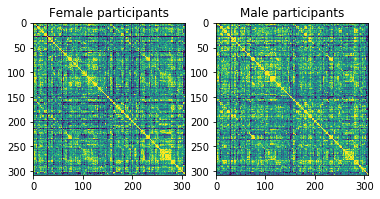

In [4]:
# create correlation matrices over the columns of df_res
M_female = scn.create_corrmat(df_female_res, names=names, method='pearson')
M_male = scn.create_corrmat(df_male_res, names=names, method='pearson')

# take a look at the matrices
fig, ax_list = plt.subplots(1, 2)
ax_list[0].imshow(M_female, vmin=0.0, vmax=0.5)
ax_list[0].title.set_text('Female participants')
ax_list[1].imshow(M_male, vmin=0.0, vmax=0.5)
ax_list[1].title.set_text('Male participants')

In [5]:
# Initialise weighted graphs from the correlation matrices
G_female = scn.BrainNetwork(network=M_female, parcellation=names, centroids=centroids)
G_male = scn.BrainNetwork(network=M_male, parcellation=names, centroids=centroids)

# Threshold the graphs at cost 10 to create binary graphs with 10% as many edges as the complete graphs
G10_female = G_female.threshold(10)
G10_male = G_male.threshold(10)

## Calculate nodal and global network measures

### Global measures

Calculate assortativity, average clustering, average shortest path length, efficiency and modularity for the male and female graphs separately.

In [6]:
G10_female.calculate_global_measures()
G10_male.calculate_global_measures()

display(G10_female.graph['global_measures'])
display(G10_male.graph['global_measures'])

{'assortativity': 0.07641717275052176,
 'average_clustering': 0.3937883550646628,
 'average_shortest_path_length': 2.334806886924151,
 'efficiency': 0.48544964032407156,
 'modularity': 0.28813763130545317}

{'assortativity': 0.08335011130326313,
 'average_clustering': 0.4026428163550175,
 'average_shortest_path_length': 2.285122044079699,
 'efficiency': 0.4907198354616811,
 'modularity': 0.3455246053678843}

### Nodal measures

Calculate betweenness, closeness, clustering, degree, participation coefficient, shortest path length for each node and and assign each node to a module, for the male and female graphs separately.

In [7]:
G10_female.calculate_nodal_measures()
G10_male.calculate_nodal_measures()

print('Female participants')
display(G10_female.report_nodal_measures().head())
print('Male participants')
display(G10_male.report_nodal_measures().head())

Female participants


,name,centroids,betweenness,closeness,clustering,degree,module,participation_coefficient,shortest_path_length,x,y,z
0,lh_bankssts_part1,"[-56.40355, -40.152663, 1.708876]",0.00281863,0.481191,0.42532,38,0,0.955679,2.07143,-56.4036,-40.1527,1.70888
1,lh_bankssts_part2,"[-53.140506, -49.843038, 8.264557]",0.00097703,0.453471,0.413043,24,0,0.956597,2.19805,-53.1405,-49.843,8.26456
2,lh_caudalanteriorcingulate_part1,"[-5.001684, 20.645903, 25.733446]",0,0.357809,1,3,1,0.555556,2.78571,-5.00168,20.6459,25.7334
3,lh_caudalmiddlefrontal_part1,"[-33.265925, 20.200202, 45.347826]",0.0282523,0.565378,0.28357,110,2,0.767851,1.76299,-33.2659,20.2002,45.3478
4,lh_caudalmiddlefrontal_part2,"[-31.958115, 2.146597, 51.26911]",0.0172985,0.52931,0.34824,70,2,0.816327,1.88312,-31.9581,2.1466,51.2691


Male participants


,name,centroids,betweenness,closeness,clustering,degree,module,participation_coefficient,shortest_path_length,x,y,z
0,lh_bankssts_part1,"[-56.40355, -40.152663, 1.708876]",0.0073552,0.515966,0.350672,59,0,0.758403,1.93182,-56.4036,-40.1527,1.70888
1,lh_bankssts_part2,"[-53.140506, -49.843038, 8.264557]",0.0122307,0.532062,0.315895,71,0,0.728427,1.87338,-53.1405,-49.843,8.26456
2,lh_caudalanteriorcingulate_part1,"[-5.001684, 20.645903, 25.733446]",8.68125e-05,0.335886,0.333333,3,1,0.555556,2.96753,-5.00168,20.6459,25.7334
3,lh_caudalmiddlefrontal_part1,"[-33.265925, 20.200202, 45.347826]",0.00129229,0.467988,0.530488,41,1,0.185604,2.12987,-33.2659,20.2002,45.3478
4,lh_caudalmiddlefrontal_part2,"[-31.958115, 2.146597, 51.26911]",0.0249336,0.563303,0.280404,100,1,0.75,1.76948,-31.9581,2.1466,51.2691


So, there are some differences between the two groups....but how do we know how meaningful those differences are?

Lets make some shuffled networks to assess the variability!

## Create shuffled networks

We can't tell how meaningful it is for male participants to have a global modularity of 0.35 when the female participants have a modularity of 0.29. Or whether to interpret the fact that `lh_caudalmiddlefrontal_part2` has 100 edges in the network derived from male participants vs "only" 70 in the network derived from female participants.

Fortunately, `scona`🍪 has a function for that: `split_groups` 🎊

In [12]:
split_group_df_dict = scn.make_corr_matrices.split_groups(df, 'male')

This dictionary has an entry for every unique value in the 'male' column. The values are dataframes.

In [16]:
display(split_group_df_dict.keys())
df_female = split_group_df_dict['male_0.0']
df_male = split_group_df_dict['male_1.0']

display(df_female.head())
display(df_male.head())

dict_keys(['male_0.0', 'male_1.0'])

,Unnamed: 0,nspn_id,occ,centre,study_primary,age_scan,sex,male,age_bin,mri_centre,...,rh_supramarginal_part5,rh_supramarginal_part6,rh_supramarginal_part7,rh_frontalpole_part1,rh_temporalpole_part1,rh_transversetemporal_part1,rh_insula_part1,rh_insula_part2,rh_insula_part3,rh_insula_part4
0,0,10356,0,Cambridge,2K_Cohort,20.761,Female,0.0,4,WBIC,...,2.592,2.841,2.318,2.486,3.526,2.638,3.308,2.583,3.188,3.089
2,2,10736,0,Cambridge,2K_Cohort,14.897,Female,0.0,1,WBIC,...,3.526,3.269,3.076,3.133,3.900,2.914,3.894,2.898,3.720,3.580
3,3,10778,0,Cambridge,2K_Cohort,20.022,Female,0.0,4,WBIC,...,2.830,2.917,2.647,2.796,3.401,3.045,3.138,2.739,2.833,3.349
4,4,10794,0,Cambridge,2K_Cohort,14.656,Female,0.0,1,WBIC,...,2.689,3.294,2.820,2.539,2.151,2.734,2.791,2.935,3.538,3.403
7,7,11049,0,Cambridge,2K_Cohort,18.335,Female,0.0,3,WBIC,...,3.441,3.099,2.954,2.693,3.455,3.071,3.274,2.758,3.351,3.364


,Unnamed: 0,nspn_id,occ,centre,study_primary,age_scan,sex,male,age_bin,mri_centre,...,rh_supramarginal_part5,rh_supramarginal_part6,rh_supramarginal_part7,rh_frontalpole_part1,rh_temporalpole_part1,rh_transversetemporal_part1,rh_insula_part1,rh_insula_part2,rh_insula_part3,rh_insula_part4
1,1,10702,0,Cambridge,2K_Cohort,16.055,Male,1.0,2,WBIC,...,3.448,3.283,2.740,3.225,4.044,3.040,3.867,2.943,3.478,3.609
5,5,10900,0,Cambridge,2K_Cohort,16.205,Male,1.0,2,WBIC,...,2.916,2.890,2.569,2.808,3.428,2.951,3.956,2.825,3.647,3.582
6,6,10975,0,Cambridge,2K_Cohort,18.628,Male,1.0,3,WBIC,...,3.094,2.992,2.705,2.855,3.980,2.634,3.596,2.727,3.287,3.531
10,10,11239,0,Cambridge,2K_Cohort,17.897,Male,1.0,2,WBIC,...,2.550,3.118,2.708,2.382,3.520,3.032,3.551,2.816,3.679,3.816
11,11,11262,0,Cambridge,2K_Cohort,17.073,Male,1.0,2,WBIC,...,3.163,2.851,2.585,2.938,3.903,2.876,3.423,2.703,3.027,3.703


In [17]:
split_group_df_dict = scn.make_corr_matrices.split_groups(df, 'male', shuffle=True)

In [19]:
display(split_group_df_dict.keys())
df_female = split_group_df_dict['male_rand_0.0']
df_male = split_group_df_dict['male_rand_1.0']

display(df_female.head())
display(df_male.head())

dict_keys(['male_rand_0.0', 'male_rand_1.0'])

,Unnamed: 0,nspn_id,occ,centre,study_primary,age_scan,sex,male,age_bin,mri_centre,...,rh_supramarginal_part6,rh_supramarginal_part7,rh_frontalpole_part1,rh_temporalpole_part1,rh_transversetemporal_part1,rh_insula_part1,rh_insula_part2,rh_insula_part3,rh_insula_part4,male_rand
0,0,10356,0,Cambridge,2K_Cohort,20.761,Female,0.0,4,WBIC,...,2.841,2.318,2.486,3.526,2.638,3.308,2.583,3.188,3.089,0.0
2,2,10736,0,Cambridge,2K_Cohort,14.897,Female,0.0,1,WBIC,...,3.269,3.076,3.133,3.900,2.914,3.894,2.898,3.720,3.580,0.0
3,3,10778,0,Cambridge,2K_Cohort,20.022,Female,0.0,4,WBIC,...,2.917,2.647,2.796,3.401,3.045,3.138,2.739,2.833,3.349,0.0
6,6,10975,0,Cambridge,2K_Cohort,18.628,Male,1.0,3,WBIC,...,2.992,2.705,2.855,3.980,2.634,3.596,2.727,3.287,3.531,0.0
9,9,11171,0,Cambridge,2K_Cohort,17.476,Female,0.0,2,WBIC,...,2.942,2.526,3.450,3.674,2.865,4.043,2.557,3.162,3.548,0.0


,Unnamed: 0,nspn_id,occ,centre,study_primary,age_scan,sex,male,age_bin,mri_centre,...,rh_supramarginal_part6,rh_supramarginal_part7,rh_frontalpole_part1,rh_temporalpole_part1,rh_transversetemporal_part1,rh_insula_part1,rh_insula_part2,rh_insula_part3,rh_insula_part4,male_rand
1,1,10702,0,Cambridge,2K_Cohort,16.055,Male,1.0,2,WBIC,...,3.283,2.740,3.225,4.044,3.040,3.867,2.943,3.478,3.609,1.0
4,4,10794,0,Cambridge,2K_Cohort,14.656,Female,0.0,1,WBIC,...,3.294,2.820,2.539,2.151,2.734,2.791,2.935,3.538,3.403,1.0
5,5,10900,0,Cambridge,2K_Cohort,16.205,Male,1.0,2,WBIC,...,2.890,2.569,2.808,3.428,2.951,3.956,2.825,3.647,3.582,1.0
7,7,11049,0,Cambridge,2K_Cohort,18.335,Female,0.0,3,WBIC,...,3.099,2.954,2.693,3.455,3.071,3.274,2.758,3.351,3.364,1.0
8,8,11064,0,Cambridge,2K_Cohort,18.519,Female,0.0,3,WBIC,...,3.147,3.014,2.839,3.846,2.804,4.034,2.767,3.319,3.524,1.0


In [25]:
for i in range(10):
    split_group_df_dict = scn.make_corr_matrices.split_groups(df, 'male', shuffle=True)

    df_female = split_group_df_dict['male_rand_0.0']
    df_male = split_group_df_dict['male_rand_1.0']

    df_female_res = scn.create_residuals_df(df_female, names, covars)
    df_male_res = scn.create_residuals_df(df_male, names, covars)
    M_female = scn.create_corrmat(df_female_res, names=names, method='pearson')
    M_male = scn.create_corrmat(df_male_res, names=names, method='pearson')
    # Initialise weighted graphs from the correlation matrices
    G_female = scn.BrainNetwork(network=M_female, parcellation=names, centroids=centroids)
    G_male = scn.BrainNetwork(network=M_male, parcellation=names, centroids=centroids)

    # Threshold the graphs at cost 10 to create binary graphs with 10% as many edges as the complete graphs
    G10_female = G_female.threshold(10)
    G10_male = G_male.threshold(10)
    G10_female.calculate_global_measures()
    G10_male.calculate_global_measures()

    print('Modularity: Female =  {:2.2f}, Male = {:2.2f}'.format(G10_female.graph['global_measures']['modularity'],
                                                                 G10_male.graph['global_measures']['modularity']))

Modularity: Female =  0.34, Male = 0.30
Modularity: Female =  0.34, Male = 0.31
Modularity: Female =  0.33, Male = 0.30
Modularity: Female =  0.31, Male = 0.33
Modularity: Female =  0.34, Male = 0.28
Modularity: Female =  0.33, Male = 0.32
Modularity: Female =  0.34, Male = 0.29
Modularity: Female =  0.32, Male = 0.32
Modularity: Female =  0.30, Male = 0.32
Modularity: Female =  0.31, Male = 0.34


In [ ]:
# Create a GraphBundle object that contains the G10 graph called "real_graph"
bundleGraphs = scn.GraphBundle([G10], ["real_graph"])

# Add ten random graphs to this bundle
# (In real life you'd want more than 10 random graphs,
# but this step can take quite a long time to run so 
# for the demo we just create 10)
bundleGraphs.create_random_graphs("real_graph", 10)